### TODO Recording:

- Open up the folder icon on the left
- Upload the twitter_training.csv file to this folder

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics

Loading the  data

In [ ]:
columns = ["id", "country", "Label", "Text"]

tweets_data = pd.read_csv("twitter_training.csv", names = columns)

tweets_data.sample(10)

,id,country,Label,Text
27968,415,ApexLegends,Positive,"However, go'n strong with the flow! Playing so..."
40896,1419,Battlefield,Negative,"Uh oh, Carmen Sandiego’s crooks & the criminal..."
11556,13186,Xbox(Xseries),Positive,.
32128,7513,LeagueOfLegends,Positive,Darius that the Hand of Prince Noxus is a grea...
56099,11228,TomClancysRainbowSix,Negative,@Rainbow6Game<unk> to play ranked a PC is diff...
48244,5881,HomeDepot,Negative,Mfs be... thinking I ’... m a fool when I say ...
57475,11458,TomClancysRainbowSix,Positive,@ Rainbow6Game thank you for blessing the enem...
50114,6203,FIFA,Irrelevant,"Pullin lost it completely at FIFA, he's about ..."
15621,3073,Dota2,Positive,this is your winner.
63952,7758,MaddenNFL,Negative,Stop the playing.


Dropping NAs and duplicates

In [ ]:
tweets_data = tweets_data.drop(columns = ["id", "country"])

tweets_data.dropna(inplace = True, axis = 0)

tweets_data = tweets_data.drop_duplicates()

tweets_data.shape

(69769, 2)

Downloading stopwords and viewing all the stop words

In [ ]:
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Custom text cleaning function is defined

In [ ]:
import string

stopwords = r"\b(?:{})\b".format("|".join(stop_words))

def clean_and_standardize_text(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses and symbols
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, stopwords, "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

Converting text labels to numeric form

In [ ]:
tweets_data["Label"] = tweets_data["Label"].replace({"Negative": 0, "Neutral": 1, "Positive": 2, "Irrelevant":3})

tweets_data.sample(5)

,Label,Text
9905,1,D PC X graphics source code stolen as leaked o...
59367,0,Twitter and snap is my personal apps. everyth...
67661,0,don’t care i’m not starting no vaccine before ...
48606,3,If the administration was running properly w/v...
48892,2,The 4th worst home improvement store


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(
    tweets_data, test_size = 0.2, stratify = tweets_data["Label"], random_state = 123)
X_train, X_val = train_test_split(
    X_train, test_size = 0.1, stratify = X_train["Label"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((50233, 2), (5582, 2), (13954, 2))

Creating Training and validation dataset from corresponding pandas dataframes

In [ ]:
BATCH_SIZE = 128

raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["Text"].values, X_train["Label"].values)).shuffle(10000).batch(batch_size = BATCH_SIZE)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["Text"].values, X_val["Label"].values)).batch(batch_size = BATCH_SIZE)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["Text"].values, X_test["Label"].values)).batch(batch_size = BATCH_SIZE)

Next, we will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you"re using the default split function, and the custom standardization function we defined above. We also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [ ]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize = clean_and_standardize_text,
    max_tokens = VOCAB_SIZE,
    output_mode = "int",
    output_sequence_length = SEQUENCE_LENGTH
)

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)

vectorize_layer.adapt(train_text)

Creating a function apply vectorization to training, validation, and test sets

In [ ]:
def vectorize_text(text, label):

    text = tf.expand_dims(text, -1)

    return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)

val_ds = raw_val_ds.map(vectorize_text)

test_ds = raw_test_ds.map(vectorize_text)

For performance improvement with GPU as done before in earlier demos

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Finding dict mapping words to their indices

In [ ]:
voc = vectorize_layer.get_vocabulary()

word_index = dict(zip(voc, range(len(voc))))

We are mounting the drive as Glove embeddings are loaded in Drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


Loading  pre-trained GloVe embeddings.
The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We"ll use the 100D ones.
Let"s make a dict mapping words (strings) to their NumPy vector representation:

In [ ]:
import os
path_to_glove_file = "/content/drive/MyDrive/glove_embeddings/glove.6B.100d.txt"

embeddings_index = {}

with open(path_to_glove_file) as f:

    for line in f:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, "f", sep = " ")

        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, Preparing a corresponding embedding matrix that we can use in a Keras Embedding layer. It"s a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer"s vocabulary.

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9155 words (845 misses)


In [ ]:
from keras.layers import LSTM, SimpleRNN, GRU, Dense, Bidirectional, Embedding, Dropout, GlobalMaxPooling1D, SpatialDropout1D

### TODO Recording:

- Starting from the cell below we are going to be training 3 different models, SimpleRNN, LSTM, BidirectionalLSTM
- First show the SimpleRNN results till the graphs
- Then come back to the top and change the model
- Each model is commented out in the cells below


We will train first below model with simple RNN. This is very slow to train in comparison with others.Test accuracy of around 0.81 is obtained after training.

Output of Embedding layer: `(batch_size, input_length, output_dim)`.

Output of spatial dropout layer (same): `(batch_size, input_length, output_dim)`.

This layer performs the same function as Dropout, however, it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead.

Output of SimpleRNN:

return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. With return_sequences the first output is the whole sequence

- whole_sequence_output has shape `[batch_size, input_length, units]`.
- final_state has shape `[batch_size, units]`.
whole_sequence_output, final_state = simple_rnn(inputs)

The whole sequence is fed into the GlobalMaxPooling1D which removes the time dimension and gives us `[batch_size, units]`


In [ ]:
model = Sequential()

model.add(Embedding(
    num_tokens, embedding_dim,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = True,
))

model.add(SpatialDropout1D(0.25))

model.add(SimpleRNN(units = 128, return_sequences = True))

model.add(GlobalMaxPooling1D())

model.add(Dense(32, activation = "tanh"))
model.add(Dense(4, activation = "softmax"))

We will train then below model with simple LSTM. Training this model gives test accuracy of around 0.84-0.85

Same shapes for input and ouput as previous model

In [ ]:
# model = Sequential()

# model.add(Embedding(
#     num_tokens, embedding_dim,
#     embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
#     trainable = True,
# ))

# model.add(SpatialDropout1D(0.25))

# model.add(LSTM(units = 128, return_sequences = True))

# model.add(GlobalMaxPooling1D())

# model.add(Dense(32, activation = "tanh"))
# model.add(Dense(4, activation = "softmax"))

# model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000200   
                                                                 
 spatial_dropout1d_2 (Spati  (None, None, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 4)                

We will train this stacked Bidirectional LSTM model

In [ ]:
# model = Sequential()

# model.add(Embedding(
#     num_tokens, embedding_dim,
#     embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
#     trainable = True,
# ))

# model.add(SpatialDropout1D(0.25))

# model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
# model.add(Bidirectional(LSTM(units = 128, return_sequences = True)))

# model.add(GlobalMaxPooling1D())

# model.add(Dense(32, activation = "tanh"))
# model.add(Dense(4, activation = "softmax"))

# model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1000200   
                                                                 
 spatial_dropout1d_3 (Spati  (None, None, 100)         0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         234496    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 256)         394240    
 onal)                                                           
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                    

Model is defined. This below particular Stacked Bidirectional network will give test accuracy of 0.87

Model is trained and compiled

In [ ]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.001),
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [ ]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/12
393/393 [==============================] - 53s 123ms/step - loss: 1.1121 - accuracy: 0.5286 - val_loss: 0.9865 - val_accuracy: 0.5876
Epoch 2/12
393/393 [==============================] - 32s 80ms/step - loss: 0.8970 - accuracy: 0.6371 - val_loss: 0.8478 - val_accuracy: 0.6618
Epoch 3/12
393/393 [==============================] - 33s 85ms/step - loss: 0.7218 - accuracy: 0.7210 - val_loss: 0.7411 - val_accuracy: 0.7137
Epoch 4/12
393/393 [==============================] - 32s 82ms/step - loss: 0.5897 - accuracy: 0.7742 - val_loss: 0.6444 - val_accuracy: 0.7546
Epoch 5/12
393/393 [==============================] - 32s 82ms/step - loss: 0.4852 - accuracy: 0.8161 - val_loss: 0.5825 - val_accuracy: 0.7818
Epoch 6/12
393/393 [==============================] - 33s 84ms/step - loss: 0.4076 - accuracy: 0.8458 - val_loss: 0.5286 - val_accuracy: 0.8060
Epoch 7/12
393/393 [==============================] - 34s 87ms/step - loss: 0.3475 - accuracy: 0.8687 - val_loss: 0.4964 - val_accuracy

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

110/110 [==============================] - 3s 31ms/step - loss: 0.4135 - accuracy: 0.8664
Loss:  0.4134906828403473
Accuracy:  0.8664182424545288


Accuracy and Loss are plotted wrt epochs

In [ ]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

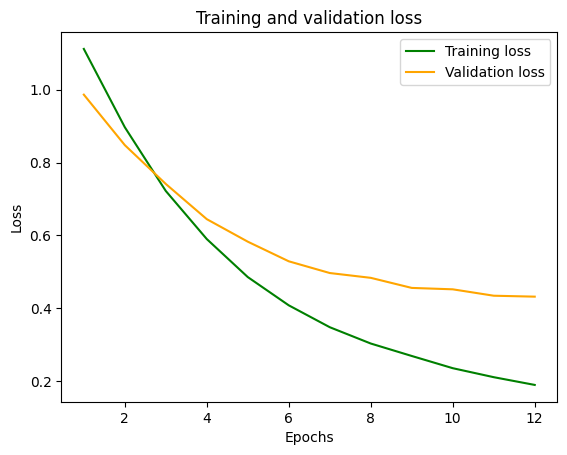

In [ ]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")
plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

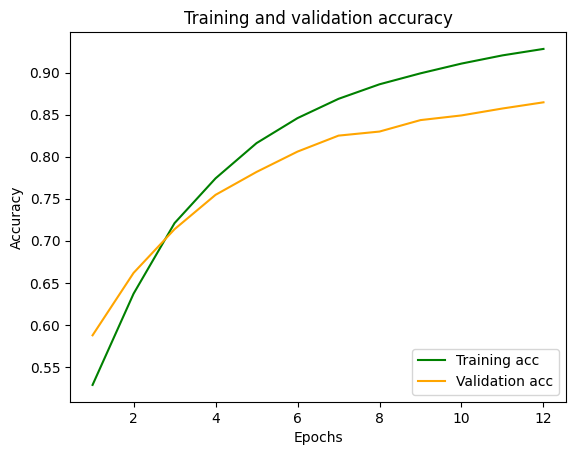

In [ ]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

### TODO Recording:

- Go back to the cell where we have defined a model and change to the next model
- SimpleRNN -> LSTM -> BidirectionalLSTM
- Move on to the next cell only after completing BidirectionalLSTM

Saving the trained model

In [ ]:
model.save("sentiment_predictor.keras")

### TODO Recording:

- Open up the folder on the right and show the sentiment_predictor.keras saved there

In [ ]:
# Loading the saved model
loaded_model = models.load_model("sentiment_predictor.keras")
loss, accuracy = loaded_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

110/110 [==============================] - 6s 31ms/step - loss: 0.4135 - accuracy: 0.8664
Loss:  0.4134906828403473
Accuracy:  0.8664182424545288


Installing and importing Keras tuner for Hyperparameter tuning

In [ ]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

When we build a model for hypertuning, we also define the hyperparameter search space in addition to the model architecture. The model you set up for hypertuning is called a hypermodel.

We can define a hypermodel through two approaches:

- By using a model builder function
- By subclassing the HyperModel class of the Keras Tuner API

We can also use two pre-defined HyperModel classes - HyperXception and HyperResNet for computer vision applications.

In this tutorial, we use a model builder function to define the sentiment classification model. The model builder function returns a compiled model and uses hyperparameters you define inline to hypertune the model.Note that as tuning takes a long time ,we would using a simpler network with a small range of parameters.

In [ ]:
def model_builder(hp):
    model = Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int("units", min_value = 128, max_value = 512 , step = 64)

    model = Sequential()
    model.add(Embedding(
      num_tokens, embedding_dim,
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
      trainable = True,
    ))

    model.add(SpatialDropout1D(0.25))

    model.add(LSTM(hp_units, return_sequences = True))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(32, activation = "tanh"))
    model.add(Dense(4))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values = [1e-3, 1e-4])

    model.compile(
        optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
        loss = losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ["accuracy"]
    )

    return model

Instantiating the tuner to perform the hypertuning. The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. In this tutorial, we use the Hyperband tuner.

To instantiate the Hyperband tuner, we must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer.

Creating  a callback to stop training early after reaching a certain value for the validation loss.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)

Running  the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

In [ ]:
tuner.search(
    train_ds,
    validation_data = val_ds,
    epochs = 10, callbacks = [stop_early]
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
  The hyperparameter search is complete. The optimal number of units in the first
  densely-connected layer is {best_hps.get("units")} and the optimal learning rate
  for the optimizer is {best_hps.get("learning_rate")}.
""")

Trial 20 Complete [00h 01m 23s]
val_accuracy: 0.5578645467758179

Best val_accuracy So Far: 0.8658186793327332
Total elapsed time: 00h 31m 42s

The hyperparameter search is complete. The optimal number of units in the first 
densely-connected layer is 448 and the optimal learning rate 
for the optimizer is 0.001.



Building  the model with the optimal hyperparameters and train it on the data for 20 epochs

In [ ]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    train_ds, validation_data = val_ds,
    epochs = 20
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
393/393 [==============================] - 46s 111ms/step - loss: 1.1035 - accuracy: 0.5311 - val_loss: 0.9791 - val_accuracy: 0.5941
Epoch 2/20
393/393 [==============================] - 33s 84ms/step - loss: 0.8752 - accuracy: 0.6485 - val_loss: 0.8188 - val_accuracy: 0.6779
Epoch 3/20
393/393 [==============================] - 33s 85ms/step - loss: 0.6826 - accuracy: 0.7359 - val_loss: 0.6749 - val_accuracy: 0.7325
Epoch 4/20
393/393 [==============================] - 34s 87ms/step - loss: 0.5309 - accuracy: 0.8003 - val_loss: 0.5771 - val_accuracy: 0.7888
Epoch 5/20
393/393 [==============================] - 34s 87ms/step - loss: 0.4090 - accuracy: 0.8470 - val_loss: 0.4983 - val_accuracy: 0.8187
Epoch 6/20
393/393 [==============================] - 34s 87ms/step - loss: 0.3291 - accuracy: 0.8764 - val_loss: 0.4766 - val_accuracy: 0.8309
Epoch 7/20
393/393 [==============================] - 35s 88ms/step - loss: 0.2849 - accuracy: 0.8930 - val_loss: 0.4625 - val_accuracy

Re-instantiating  the hypermodel and training it with the optimal number of epochs from above.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(
    train_ds, validation_data = val_ds,
    epochs = best_epoch
)

Epoch 1/15
393/393 [==============================] - 48s 117ms/step - loss: 1.1043 - accuracy: 0.5301 - val_loss: 0.9832 - val_accuracy: 0.5863
Epoch 2/15
393/393 [==============================] - 34s 87ms/step - loss: 0.8746 - accuracy: 0.6486 - val_loss: 0.8255 - val_accuracy: 0.6711
Epoch 3/15
393/393 [==============================] - 34s 86ms/step - loss: 0.6786 - accuracy: 0.7377 - val_loss: 0.6731 - val_accuracy: 0.7393
Epoch 4/15
393/393 [==============================] - 34s 85ms/step - loss: 0.5199 - accuracy: 0.8032 - val_loss: 0.5692 - val_accuracy: 0.7900
Epoch 5/15
393/393 [==============================] - 34s 86ms/step - loss: 0.4092 - accuracy: 0.8473 - val_loss: 0.5237 - val_accuracy: 0.8119
Epoch 6/15
393/393 [==============================] - 34s 86ms/step - loss: 0.3281 - accuracy: 0.8770 - val_loss: 0.4796 - val_accuracy: 0.8321
Epoch 7/15
393/393 [==============================] - 34s 87ms/step - loss: 0.2709 - accuracy: 0.8996 - val_loss: 0.4329 - val_accuracy

Evaluating  the hypermodel on the test data.

In [ ]:
eval_result = hypermodel.evaluate(test_ds)

print("[test loss, test accuracy]:", eval_result)

110/110 [==============================] - 3s 29ms/step - loss: 0.4751 - accuracy: 0.8638
[test loss, test accuracy]: [0.47514185309410095, 0.8637666702270508]
